# Plot the number of proteins identified in Proteomics

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None

## Read Data

### Proteomics Data

In [2]:
# Read log2-transformed LFQ intensity from shaving data
shaving = pd.read_excel('input_files/20220216_identified_quantified_proteins_shaving.xlsx', #noqa: E501
                            sheet_name = 'identified_proteins',
                            header = 1)

sn = pd.read_excel('input_files/20220428_identified_quantified_supernatant.xlsx',
                        sheet_name = 'identified_proteins',
                        header = 1)

# Fix stupid names with spaces
shaving.columns = shaving.columns.str.replace(' ', '')
shaving = shaving[:-1]

sn.columns = sn.columns.str.replace(' ', '')
sn = sn[:-1]

### Read Metadata

In [3]:
# Load full protein info
full_sequences = pd.read_csv("input_files/sequences_annotated.csv",
                            index_col = 0)

## Prepare Data

### Merge Metadata

In [4]:
shaving_annotated = shaving.merge(full_sequences[['SeqID',
                                                  'shortname',
                                                  'description',
                                                  'amylosome_component']],
                           left_on = 'ProteinIDs',
                           right_on = 'SeqID',
                           how = 'left',
                           validate = '1:m')

sn_annotated = sn.merge(full_sequences[['SeqID',
                                           'shortname',
                                                 'description',
                                                 'amylosome_component']],
                           left_on = 'ProteinIDs',
                           right_on = 'SeqID',
                           how = 'left',
                           validate = '1:m')

shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.astype('boolean') #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.astype('boolean')

### Define Conditions

In [5]:
# Define Names of timepoints
time_names = ['Mid-log.','End-log.','Late stat.']

# Define Conditions with Shorthand and Timepoints
conditions = {'Fructose': ['F',[10, 14, 20]],
              'Pullulan': ['P',[8,12,20]],
              'Starch': ['S',[8,12,20]],
              'RS': ['resistantS',[5,10,20]]}

# Make list for easier handling
include_columns = []

for _, [shorthand, times] in conditions.items():
     # Iterate over Timepoints
    for t in range(3):
        # Iterate over Replicates
        for i in range(1,4):
            include_columns.append(f'{shorthand}{times[t]}_{i}')

sn_annotated = sn_annotated[sn_annotated[include_columns].notna().any(axis=1)]
shaving_annotated = shaving_annotated[shaving_annotated[include_columns].notna().any(axis=1)] #noqa: E501

### Identified Proteins over Time

#### Make Timeseries DataFrame

In [6]:
# Which "Unique Peptide Count" should be considered positive?
min_upc = 2

# Dataframe for Results
timeseries = pd.DataFrame(columns = ['Carb',
                                    'Time_h',
                                    'Timepoint',
                                    'n_identified_shaving_all',
                                    'set_identified_shaving',
                                    'n_identified_sn_all',
                                    'set_identified_sn',
                                    'replicate',
                                    'col_basename',
                                    ])

# Iterate over Carbon Sources
for carb, [shorthand, times] in conditions.items():

    # Iterate over Timepoints
    for t in range(3):

        # Iterate over Replicates
        for i in range(1,4):
            col_basename = f'{shorthand}{times[t]}_{i}'

            # Consider proteins, if at least min_upc unique peptides were detected

            temp = {'Carb': carb,
                    'Time_h': times[t],
                    'Timepoint': time_names[t],
                    'n_identified_shaving_all': shaving_annotated.loc[shaving_annotated[col_basename] >= min_upc, #noqa: E501
                                                                      col_basename].count(),
                    'set_identified_shaving': set(shaving_annotated.loc[shaving_annotated[col_basename] >= min_upc, #noqa: E501
                                                                      'MajorityproteinIDs'].to_list()),
                    'n_identified_sn_all': sn_annotated.loc[sn_annotated[col_basename] >= min_upc, #noqa: E501
                                                            col_basename].count() ,
                    'set_identified_sn': set(sn_annotated.loc[sn_annotated[col_basename] >= min_upc, #noqa: E501
                                                                      'MajorityproteinIDs'].to_list()),
                    'replicate': i,
                    'col_basename': col_basename,
                    }

            timeseries.loc[len(timeseries)] = temp

#### Make merge columns

In [7]:
amylosome_set = set(full_sequences[full_sequences.amylosome_component].SeqID.to_list())

for index, row in timeseries.iterrows():

    # Make "either" set
    union = row['set_identified_shaving'].union(row['set_identified_sn'])

    timeseries.at[index, "set_identified_either"] = [union]
    timeseries.loc[index, "n_identified_either"] = len(union)

    # Make "amylosome" sets:
    timeseries.loc[index,
                   "n_identified_shaving_amylosome"] = len(row['set_identified_shaving']
                                                                  & amylosome_set)
    timeseries.loc[index,
                   "n_identified_sn_amylosome"] = len(row['set_identified_sn']
                                                              & amylosome_set)

    timeseries.loc[index,
                   "n_identified_either_amy"] = len(union & amylosome_set)

    # Make ratio
    timeseries.loc[index,
                   "ratio_shaving_sn"] = (row['n_identified_shaving_all'] /
                                            row['n_identified_sn_all'])


## Plot

In [8]:
# Carb Palette defined based on ColorBrewer 5-class BrBG
carb_palette = {"Pullulan": "#a6611a",
                "Fructose": "#969696",
                "Starch": "#80cdc1",
                "RS": "#018571",
                }

### Diagnostic Plot: All protein counts

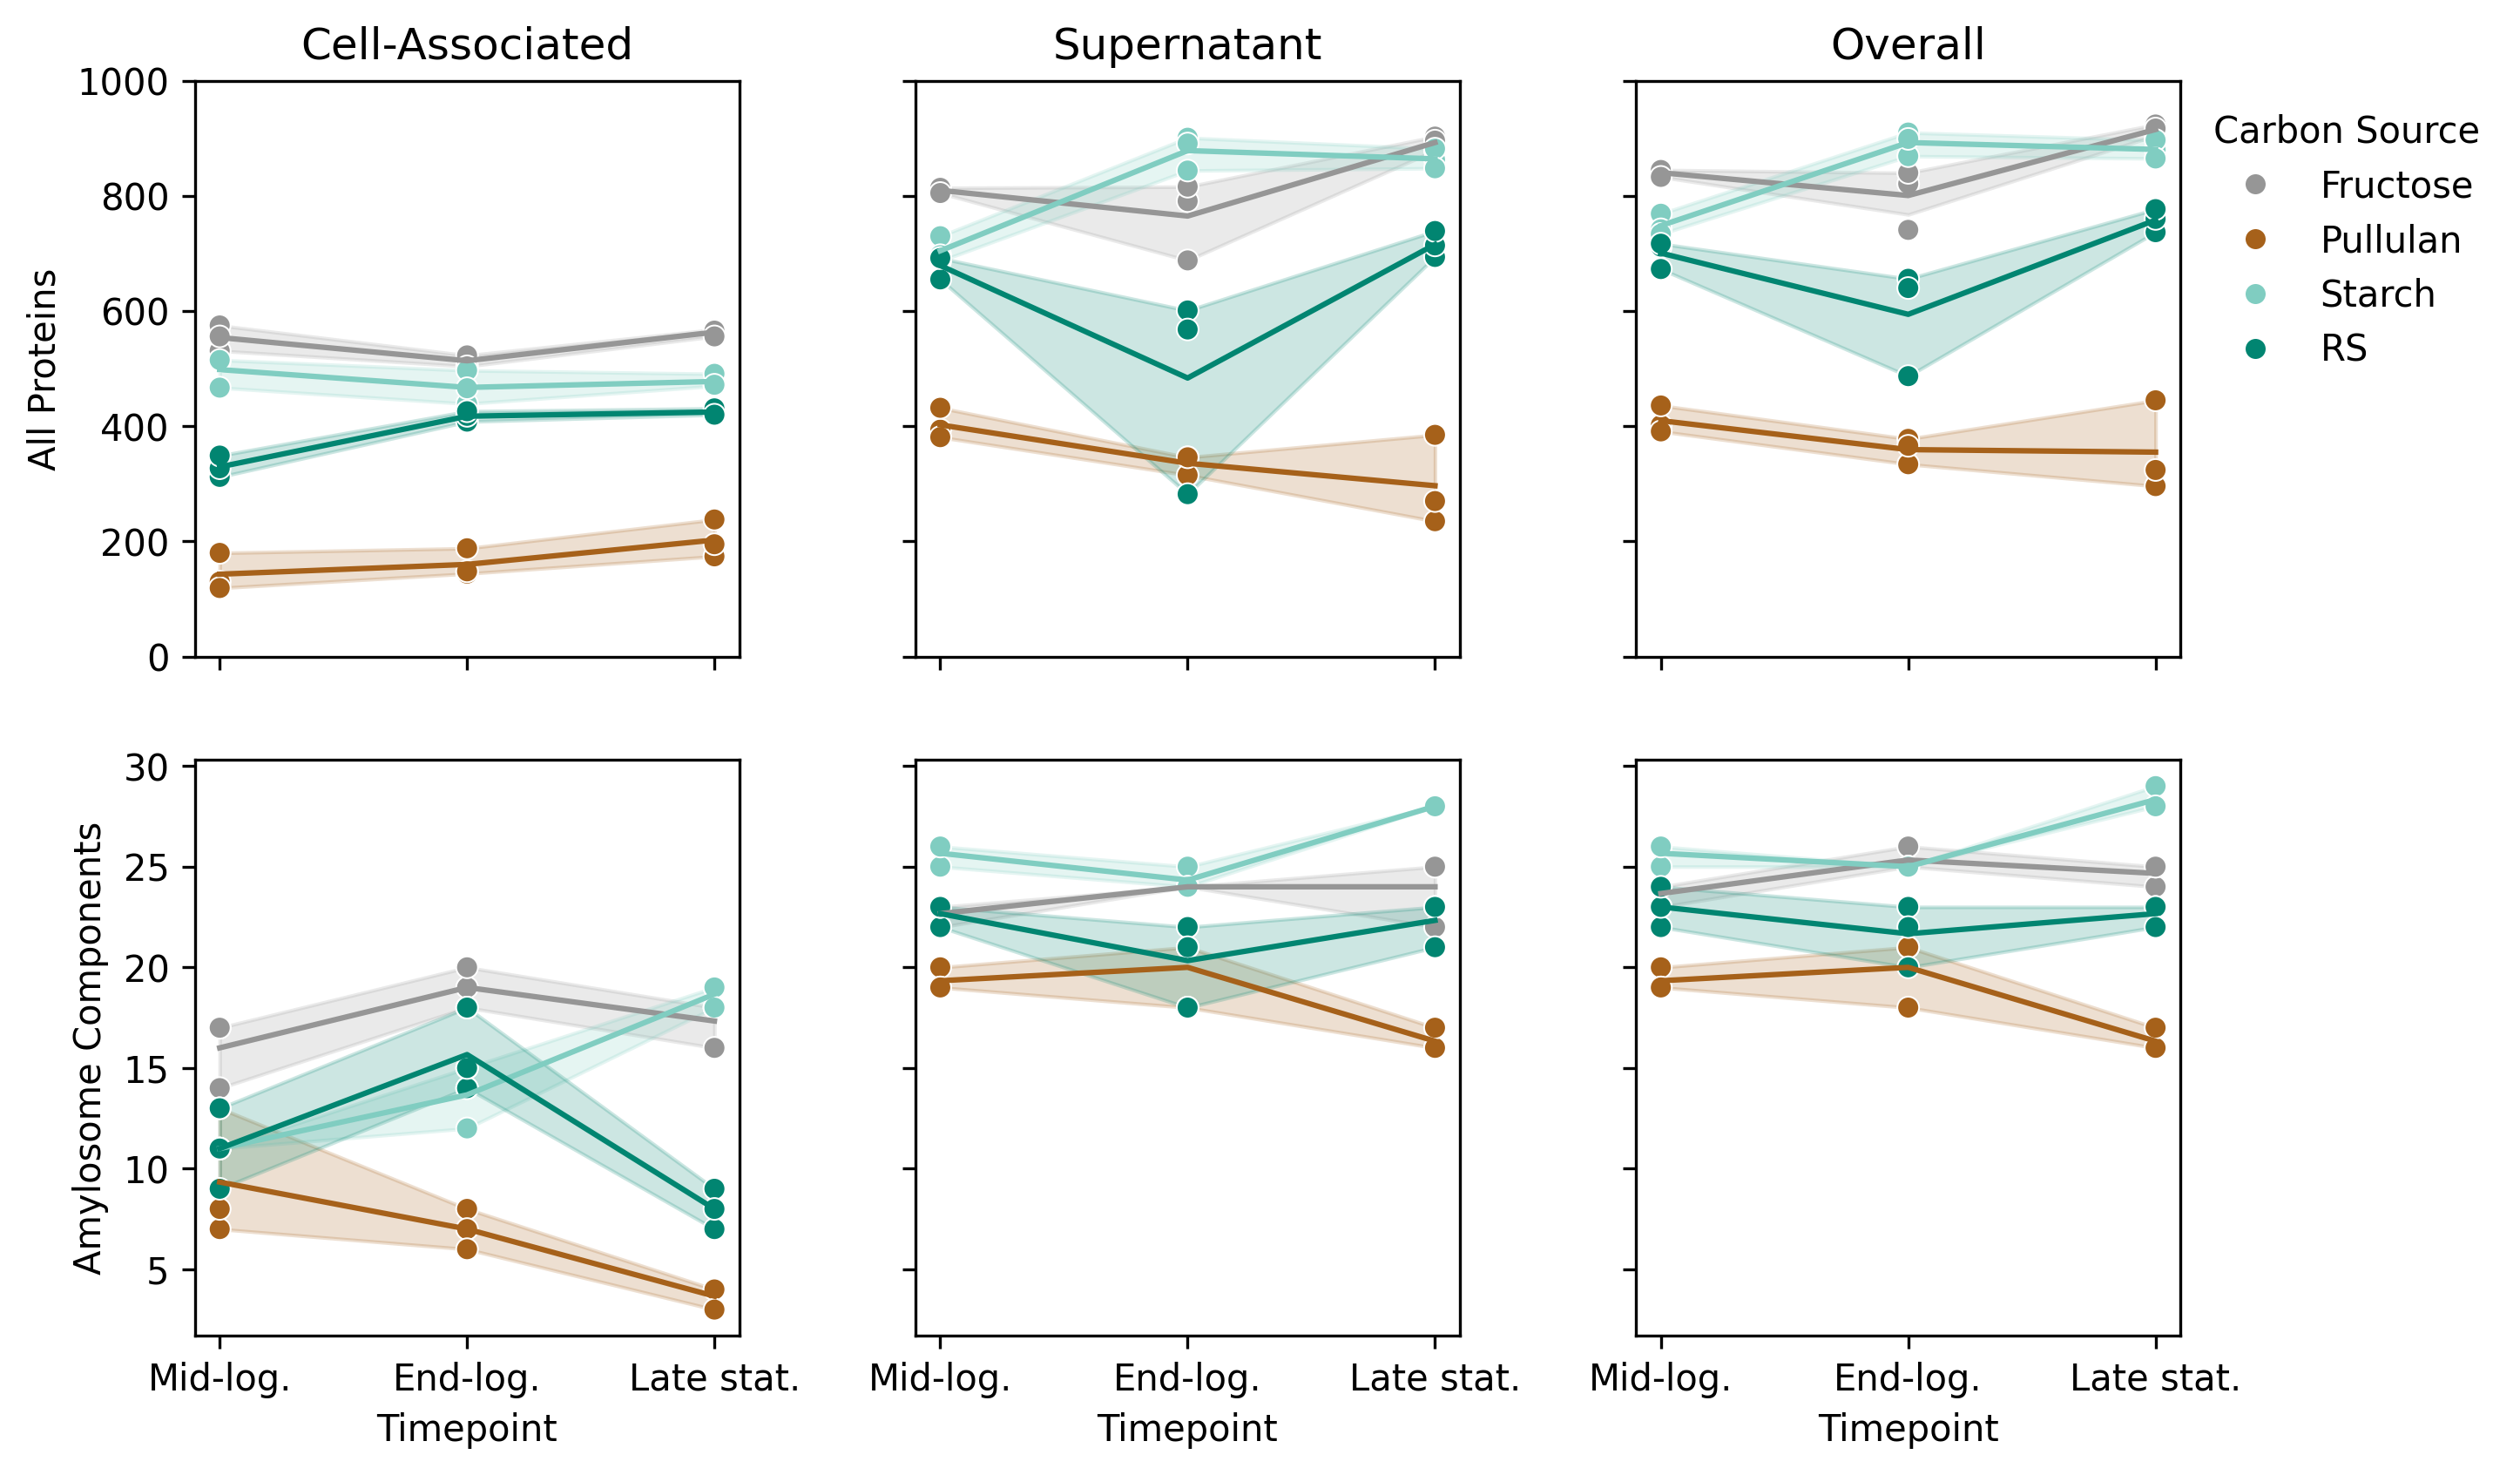

In [9]:
# Plot into panels
# First row: all proteins
# Second row: amylosome-only

figure, axis = plt.subplots(nrows= 2,
                            ncols = 3,
                            dpi=300,
                            figsize=(10,6),
                            sharex = True,
                            sharey = "row")

# First, plot counts in cell shaving
axis[0,0].set_title('Cell-Associated')
axis[0,0].set_ylim([0,1000])

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_shaving_all",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = axis[0,0],
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_shaving_all",
                hue = "Carb",
                palette = carb_palette,
                ax = axis[0,0],
                legend = False,
                )

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_shaving_amylosome",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = axis[1,0],
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_shaving_amylosome",
                hue = "Carb",
                palette = carb_palette,
                ax = axis[1,0],
                legend = False,
                )

# Then, plot counts in supernatant
axis[0,1].set_title('Supernatant')

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_sn_all",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = axis[0,1],
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_sn_all",
                hue = "Carb",
                palette = carb_palette,
                ax = axis[0,1],
                legend = False,
                )

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_sn_amylosome",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = axis[1,1],
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_sn_amylosome",
                hue = "Carb",
                palette = carb_palette,
                ax = axis[1,1],
                legend = False,
                )

# Then, plot counts for both combined
axis[0,2].set_title('Overall')

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_either",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = axis[0,2],
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_either",
                hue = "Carb",
                palette = carb_palette,
                ax = axis[0,2],
                legend = True,
                )

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_either_amy",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = axis[1,2],
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_either_amy",
                hue = "Carb",
                palette = carb_palette,
                ax = axis[1,2],
                legend = False,
                )

for ax in axis.flatten():
    ax.set_ylabel('')

axis[0,0].set_ylabel("All Proteins")
axis[1,0].set_ylabel("Amylosome Components")

sns.move_legend(axis[0,2],
                'upper left',
                bbox_to_anchor=(1,1),
                title = "Carbon Source",
                frameon = False)

figure.tight_layout(pad=2)

plt.show()

### For Figure

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18853/142999342.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18853/142999342.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = ax.get_xticklabels(),


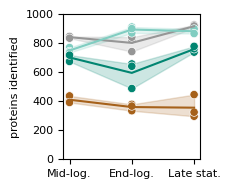

In [11]:
inch = 2.54 # one inch is 2.54 cm

fig, ax = plt.subplots(figsize=(6 / inch,
                                5 / inch))

sns.lineplot(timeseries,
             x = "Timepoint",
             y = "n_identified_either",
             hue = "Carb",
             palette = carb_palette,
             err_style = "band",
             ax = ax,
             legend = False,
             )

sns.scatterplot(timeseries,
                x = "Timepoint",
                y = "n_identified_either",
                hue = "Carb",
                palette = carb_palette,
                ax = ax,
                legend = False,
                )

ax.set_ylim([0,1000])

ax.set_ylabel("proteins identified",
              fontsize = 8)
ax.set_yticklabels(labels = ax.get_yticklabels(),
                   fontsize = 8)

ax.set_xlabel('')
ax.set_xticklabels(labels = ax.get_xticklabels(),
    rotation = 0,
                   fontsize = 8,)

fig.tight_layout(pad=1)